<h1><center>MLP</center></h1?>


<h3>Imports</h3>

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Initializer
import re 
import nltk

# Config for GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# Having issues with gpu, so running cpu instead
tf.config.set_visible_devices([], 'GPU')


<h3>Loading the training,Testing and pre-trained glove vector's</h3>

This section of code I load the training, testing and glove embedding vectors

In [11]:
# Load the training dataset
df_training = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\train.csv', delimiter=',')
X_train = df_training.values[:, 0]
y_train = np.array(df_training.values[:, 1], dtype=np.float32)

# Load the testing 
df_testing = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\test.csv')  
X_test = np.array(df_testing.values[:, 0])
y_test = np.array(df_testing.values[:, 1], dtype=np.float32)

# Load the GLoVe word embeddings
filename = "C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\glove.6B.300d.txt.word2vec"
glove = KeyedVectors.load_word2vec_format(filename, binary=False) # for now binary is true

<h3>Pre-processing - Cleaning the data</h3>
In this section I apply several pre-processing steps to clean the training and testing data from noise that would negatively affect the models ability to learn from the model. 

These steps include: 
- Removing special character's/words ( punctuation / urls )
- Remove stopwords any words that are contained within the sentence's that exist within the nltk.stopwords repository are removed from the sentences
- Perform lemmanzation: moving words to their roots for better text analysis.

In [12]:
# Preprocess the data
# Preprocess the text: lowercase, remove special characters, tokenize
def remove_special_characters_and_tokenise(text):
    # Lower case the text
    text = text.lower()
    # Remove special characters
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = []
    for word in nltk.word_tokenize(text):
        tokens.extend(re.findall(r'\b\w+\b', word))  # Split combined words into separate tokens
    return tokens

# Remove stopwords
def remove_stopwords(tokens):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    return [word for word in tokens if word not in stopwords]

# Lemmatization
def perform_lemmatization(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Clean the sentence: Apply the cleaning process to a single sentence
def clean_sentence(sentence):
    tokens = remove_special_characters_and_tokenise(sentence)
    tokens = remove_stopwords(tokens)
    tokens = perform_lemmatization(tokens)
    return tokens

# Preprocess the data: Apply the cleaning process to all sentences in data
def pre_process_data(data):
    token_arrays = []  
    for sentence in data:
        tokens = clean_sentence(sentence)
        token_arrays.append(np.array(tokens))

    return [' '.join(tokens) for tokens in token_arrays]

# Apply pre-processing to the training and testing data
X_train = pre_process_data(X_train)
X_test = pre_process_data(X_test)

# Fit tokenizer
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
num_words = len(tokenizer.word_index) + 1  # Add 1 for padding token

# Tokenise the training data and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the training and test data sentences to the same length
max_len = max([len(x) for x in X_train]) 
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# Convert tokenized words to glove embeddings
def embed_text_glove(token_sequences, word_index):
    embedded_text = []
    for sequence in token_sequences:
        embedded_sentence = []
        for word_idx in sequence:  # Rename the loop variable to word_idx
            try:
                if (word_idx == 0):
                    embedded_sentence.append(np.zeros(300))
                    continue
                word = next(word for word, index in word_index.items() if index == word_idx)  # Rename word_index to word_idx
                embedded_word = glove[word]
                embedded_sentence.append(embedded_word)
            except KeyError:
                embedded_sentence.append(np.zeros(300))
        embedded_text.append(embedded_sentence)
    return np.array(embedded_text)

# Embed the training and test data
X_train_glove_embedded = embed_text_glove(X_train, tokenizer.word_index)
X_test_glove_embedded = embed_text_glove(X_test, tokenizer.word_index)

# Construct the model weight matrix for embedding layer
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if word in glove.key_to_index:
        embedding_vector = glove[word]
        embedding_matrix[i] = embedding_vector

## MLP with flattened glove embedded word vector

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 1324505   
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,324,511
Trainable params: 1,324,511
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
16/16 [==============================] - 3s 67ms/step - loss: 0.5583 - accuracy: 0.7387 - val_loss: 0.4503 - val_accuracy: 0.8100
Epoch 2/10
16/16 [==============================] - 1s 36ms/step - loss: 0.3379 - accuracy: 0.8838 - val_loss: 0.3850 - val_accuracy: 0.8400
Epoch 3/10
16/16 [==============================] - 1s 36ms/step - loss: 0.2377 - accuracy: 0.9375 - val_loss: 0.3620 - val_accuracy: 0.8575
Epoch 4/10
16/16 [==============================] - 1s 33ms/step - loss: 0.1785 - accuracy: 0.9600 - val_loss: 0.3595 - val_accuracy: 0.8550
Epoch 5/10
16/16 [==============================] - 0s 32ms/step - loss: 0.1399 - accuracy: 0.9700 - val_loss: 0.3725 - val_accuracy: 0.8475
Epoch 6/10
16/16 [==============================] - 1s 34ms/step - loss: 0.1135 - accuracy: 0.9787 - val_loss: 0.3723 - val_accuracy: 0.8425
Epoch 7/10
16/16 [==============================] - 1s 33ms/step - loss: 0.0936 - accuracy: 0.9844 - val_loss: 0.3762 - val_accuracy: 0.8375
Epoch 8/10
16

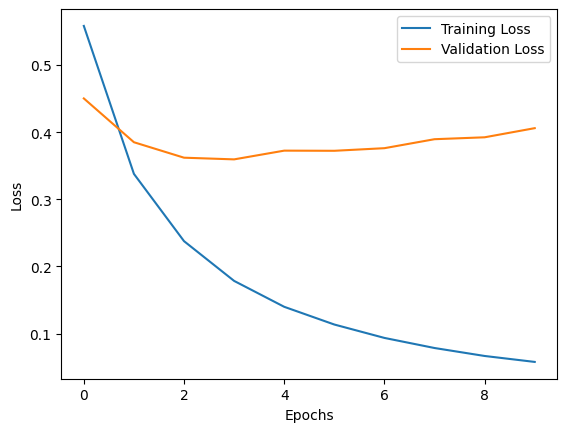

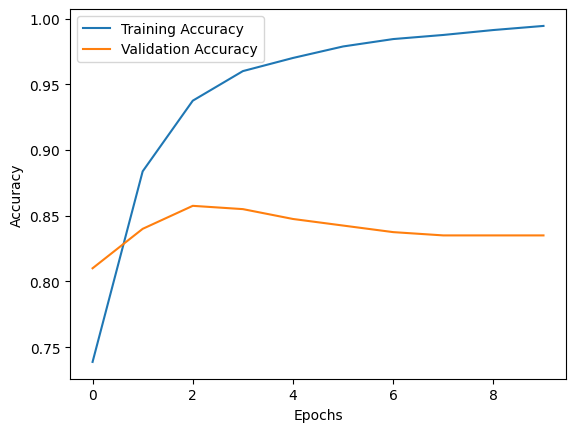

In [5]:
flattened_X_train = np.reshape(X_train_glove_embedded, (2000, -1))

# Define the model
model_single_vector = Sequential()

# Add Dense layers
model_single_vector.add(Dense(5, activation='relu', input_shape=(max_len * 300,)))  # Assuming max_len * 300 for the input shape
# model_single_vector.add(Dense(3, activation='relu'))
model_single_vector.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model_single_vector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_single_vector.summary()

# Fit the model on the training data
history = model_single_vector.fit(flattened_X_train, y_train, batch_size=100, epochs=10, validation_split=0.2)

# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Get validation history
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test on flattens X_test_glove_embedded



## MLP using keras embedding layer

USING EMBEDDING LAYER THIS TIME

In [ ]:
from tensorflow.keras.initializers import he_uniform

vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token

print (max_len)
print (vocab_size)

model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len))  # Specify input length here
model_2.add(Flatten())  # Specify input shape here
model_2.add(Dense(10, activation='relu', kernel_initializer=he_uniform(), kernel_regularizer=l1(0.001)))
model_2.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(0.001)))

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print ('X_train: ', X_train.shape)
print ('y_train: ', y_train.shape)
history = model_2.fit(flattened_X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, verbose=2)


# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

NameError: name 'tokenizer' is not defined

Epoch 1/30
63/63 - 66s - loss: 41.4190 - acc: 0.5025 - val_loss: 16.4211 - val_acc: 0.4500 - 66s/epoch - 1s/step
Epoch 2/30


KeyboardInterrupt: 

In [ ]:
predictions = model_2.predict(X_test)
from sklearn.metrics import classification_report
report = classification_report(y_test, predictions.round())
print (report)